# スコア検定



## 概要

### スコア関数

分布$f(x|\theta)$からランダムに得られた$n$個のサンプルを$X = (X_1, \cdots, X_n)$とする。

$X$の同時確率関数（尤度）を$\prod_{i=1}^n f(x_i|\theta)$を$f_n(x|\theta)$と表す。

対数尤度$l(\theta, X) = \log f_n(X|\theta)$の導関数

$$
l'_n(\theta, X) = \frac{d}{d \theta} \log f_n(X|\theta)
$$

を **スコア関数** （score function）という。


### フィッシャー情報量

スコア関数の2乗の期待値

$$
I_n(\theta)=E\left[\left\{l'_n(\theta, \boldsymbol{X})\right\}^2\right]=E\left[\left\{\frac{d}{d \theta} \log f_n(\boldsymbol{X} \mid \theta)\right\}^2\right]
$$

を **フィッシャー情報量** という。



### スコア関数の性質

$$
E[l'_n(\theta, X)] = 0\\
Var[l'_n(\theta, X)] = E[-l''_n(\theta,X)]= I_n(\theta) = n I_1(\theta)
$$

（$I_1(\theta)$はサンプル1つのフィッシャー情報量）

となるので、中心極限定理により、$n$が真値のとき

$$
l'(\theta, \boldsymbol{X}) / \sqrt{n I_1(\theta)} \rightarrow_d \mathcal{N}(0,1)
$$

という漸近正規性があるので、これを使って検定ができる

:::{dropdown} TODO: 導出を追う
$l'_1(\theta, X_i) = \{(d/d\theta) f(x|\theta)\} / f(x|\theta)$と書けるらしいので（？）

$$
\begin{aligned}
E\left[l'_1\left(\theta, X_i\right)\right] & =\int\left\{\frac{(d / d \theta) f(x \mid \theta)}{f(x \mid \theta)}\right\} f(x \mid \theta) d x \\ & =\int \frac{d}{d \theta} f(x \mid \theta) d x=\frac{d}{d \theta} \int f(x \mid \theta) d x=\frac{d}{d \theta} 1=0
\end{aligned}
$$
:::

### スコア検定

$$
H_0: \theta = \theta_0
\quad \text{v.s.} \quad
H_1: \theta \neq \theta_0
$$

に対して、

$$
R=\left\{\boldsymbol{x} \in \mathcal{X} \mid | l'_n\left(\theta_0, \boldsymbol{x}\right) \mid / \sqrt{n I_1\left(\theta_0\right)} \geq z_{\alpha / 2}\right\}
$$

を棄却域とする検定を **スコア検定** （score test） という。


## 例

（とりあえず作ったが合ってるか不明。とくに2階微分のところ）

ガンマ分布っぽいデータがあったとする。

ガンマ分布のshapeパラメータ$\alpha$は、$\alpha=1$のとき指数分布と一致する。

データが指数分布（$\alpha\neq1$）かガンマ分布（$\alpha=1$）なのか検定する（ガンマ分布のscaleパラメータは既知とする）

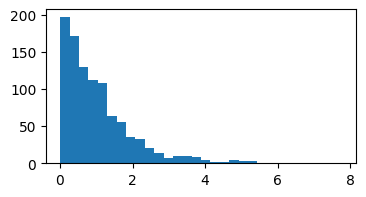

In [40]:
import numpy as np

np.random.seed(0)
n = 1000
alpha = 1.1  # 知りたいパラメータ
scale = 1    # 今回は既知とする
x = np.random.gamma(shape=alpha, scale=scale, size=n)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[4,2])
ax.hist(x, bins=30)
fig.show()

In [41]:
from scipy.stats import gamma

def neg_log_likelihood(alpha, scale, data):
    """負の対数尤度関数"""
    return -np.sum(gamma.logpdf(data, a=alpha, scale=scale))

In [42]:
from scipy.optimize import minimize_scalar

result = minimize_scalar(neg_log_likelihood, args=(scale, x), bounds=(0.01, 10), method='bounded')
alpha_hat = result.x

# 最尤推定量
alpha_hat

1.0752251626781302

approx_fprimeで数値微分する

In [43]:
from scipy.optimize import approx_fprime

grad = approx_fprime(
    alpha_hat, # 勾配を計算する点
    f=lambda a: neg_log_likelihood(a, scale, x), # 対象の関数
    epsilon=np.sqrt(np.finfo(float).eps)
)
grad

array([-0.00021362])


$E[-l''_n(\theta,X)]= I_n(\theta)$を使う


In [68]:
def derivative(x, f, epsilon=np.sqrt(np.finfo(float).eps)):
    """1階微分の勾配を計算する関数"""
    return approx_fprime(x, f, epsilon)

def second_order(x0, f):
    """2階微分を直接行う関数はないので2階approx_fprimeを行う"""
    def first_order(x):
        return derivative(x, f)
    return derivative(x0, first_order)

grad = derivative(
    alpha_hat, # 勾配を計算する点
    f=lambda a: neg_log_likelihood(a, scale, x), # 対象の関数
    epsilon=np.sqrt(np.finfo(float).eps)
)[0]
hess = second_order(
    alpha_hat,
    f=lambda a: neg_log_likelihood(a, scale, x)
)[0]

In [69]:
# I = E[-l''(θ)] だが、マイナスのまま√とれないので結局絶対値にしないといけないような…
I = abs( -hess )
score = abs(grad) / np.sqrt(I)
score

3.854228863074666e-06

In [74]:
from scipy.stats import norm

z = norm.ppf(1 - 0.025, loc=0, scale=1)
score >= z

False